<a href="https://colab.research.google.com/github/austineDboss/Exercises-and-Projects/blob/master/case_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [221]:
#import needed libraries
%pylab inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style; style.use('ggplot')
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report,cohen_kappa_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [138]:
#The below code mounts google drive folder to google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train = pd.read_csv("/content/drive/My Drive/colab/drugs/drugsComTrain_raw.csv")
test = pd.read_csv("/content/drive/My Drive/colab/drugs/drugsComTest_raw.csv")

In [140]:
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [0]:
conditions = train.condition.value_counts().sort_values(ascending=False)

In [142]:
conditions[:10]

Birth Control      28788
Depression          9069
Pain                6145
Anxiety             5904
Acne                5588
Bipolar Disorde     4224
Insomnia            3673
Weight Loss         3609
Obesity             3568
ADHD                3383
Name: condition, dtype: int64

In [0]:
plt.rcParams['figure.figsize'] = [12, 8]

Text(0, 0.5, 'count')

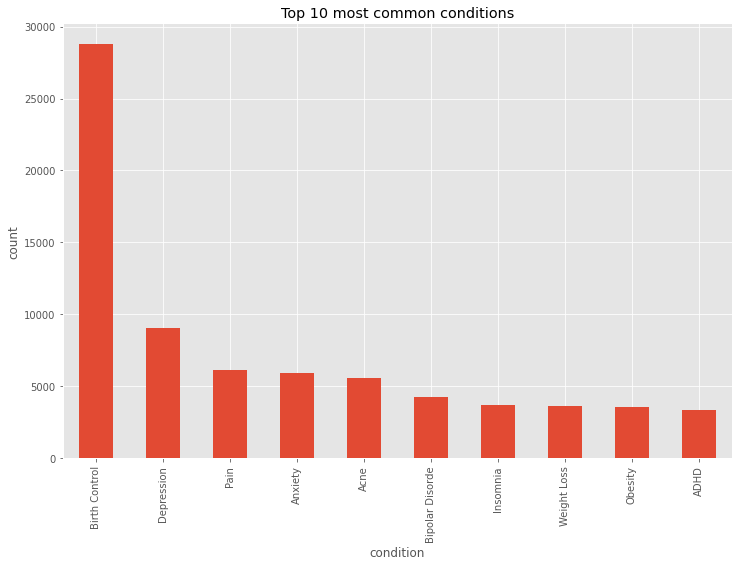

In [144]:
conditions[:10].plot(kind='bar')
plt.title('Top 10 most common conditions')
plt.xlabel('condition')
plt.ylabel('count')

Text(0, 0.5, 'Count')

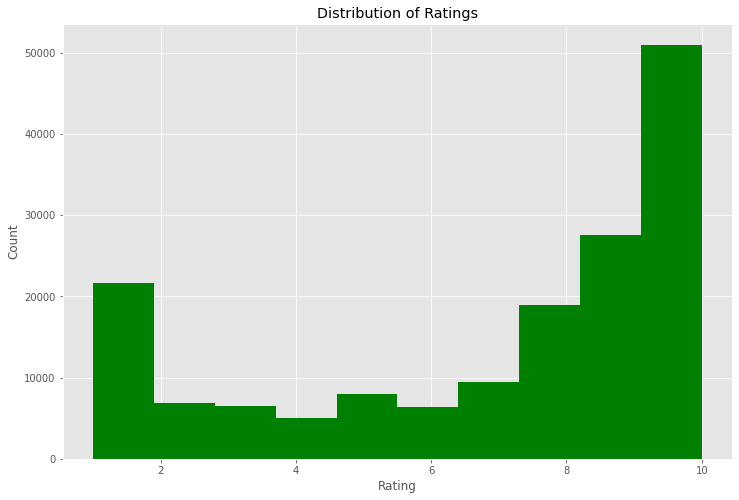

In [145]:
train.rating.hist(color='green')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
#plt.xticks([i for i in range(1,11)]);


Text(0, 0.5, 'Useful Count')

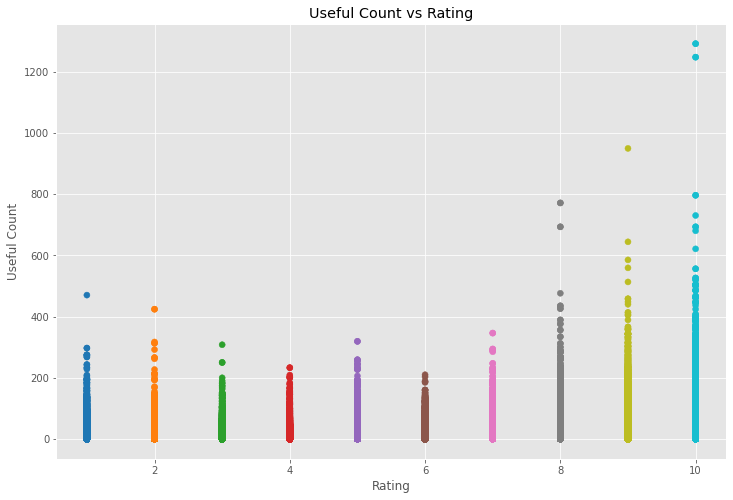

In [146]:
plt.scatter(train.rating, train.usefulCount, c=train.rating.values, cmap='tab10')
plt.title('Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Useful Count')


In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer

samples = train['review']
tests = test['review']

In [0]:
tokenizer = Tokenizer(num_words = 1500)
tokens = Tokenizer(num_words = 1500)

In [194]:
tokenizer.fit_on_texts(samples)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 51429 unique tokens.


In [195]:
# Make one hot samples
data = tokenizer.texts_to_matrix(samples, mode='binary')
data.shape

(161297, 1500)

In [0]:
#Create 3 categpories for positive neutral and negative ratings
#label = 2, when rating > 6 , meaning positive rating
#label = 1, when rating = 5 or 6, meaning neutral
#label = 0, when rating < 5, meaning negative
labels = train['rating'].values
labels = 2.0 * (labels > 6) + 1.0*(labels == 5) + 1.0*(labels == 6)
test_labels = test['rating'].values
test_labels = 2.0 * (test_labels > 6) + 1.0*(test_labels == 5) + 1.0*(test_labels == 6)

In [197]:
labels[:10]

array([2., 2., 1., 2., 2., 0., 0., 2., 0., 2.])

In [0]:
#Split into training and validation sets
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(data, labels,test_size = 0.3, random_state = 20)

In [0]:
from tensorflow.keras.utils import to_categorical

In [0]:
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

In [201]:
# [0,0,1] = 2 , [1,0,0] = 0, [0,1,0] = 1

y_train_cat[:20]

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [202]:
y_train[:10]

array([2., 0., 2., 2., 2., 0., 2., 2., 2., 2.])

In [203]:
test_labels.shape

(53766,)

##Train the model

In [204]:
#Create a simple sequential model
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Dropout


model = Sequential()
model.add(Dense(512, input_dim = 1500))
model.add(Activation('relu'))
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(128, activation = 'relu'))
model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics = [tfa.metrics.CohenKappa(num_classes = 3)])
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 512)               768512    
_________________________________________________________________
activation_41 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_77 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_78 (Dense)             (None, 3)                 387       
_________________________________________________________________
activation_42 (Activation)   (None, 3)                 0         
Total params: 933,123
Trainable params: 933,123
Non-trainable params: 0
_______________________________________________

In [205]:
%%time
history = model.fit(x_train, y_train_cat,
                    epochs = 10,
                    batch_size = 32,
                    verbose = 1,
                    validation_data = (x_val, y_val_cat))

Train on 112907 samples, validate on 48390 samples
Epoch 1/10
112907/112907 [==============================] - 24s 208us/sample - loss: 0.5706 - cohen_kappa: 0.5021 - val_loss: 0.5322 - val_cohen_kappa: 0.5259
Epoch 2/10
112907/112907 [==============================] - 23s 204us/sample - loss: 0.4123 - cohen_kappa: 0.6690 - val_loss: 0.4803 - val_cohen_kappa: 0.6303
Epoch 3/10
112907/112907 [==============================] - 23s 207us/sample - loss: 0.2148 - cohen_kappa: 0.8408 - val_loss: 0.5067 - val_cohen_kappa: 0.6665
Epoch 4/10
112907/112907 [==============================] - 24s 209us/sample - loss: 0.1024 - cohen_kappa: 0.9286 - val_loss: 0.6582 - val_cohen_kappa: 0.6769
Epoch 5/10
112907/112907 [==============================] - 24s 215us/sample - loss: 0.0630 - cohen_kappa: 0.9561 - val_loss: 0.7496 - val_cohen_kappa: 0.6852
Epoch 6/10
112907/112907 [==============================] - 23s 206us/sample - loss: 0.0441 - cohen_kappa: 0.9687 - val_loss: 0.8473 - val_cohen_kappa: 0.

## plot the accuracy(cohens kappa) and loss for the training and validation data

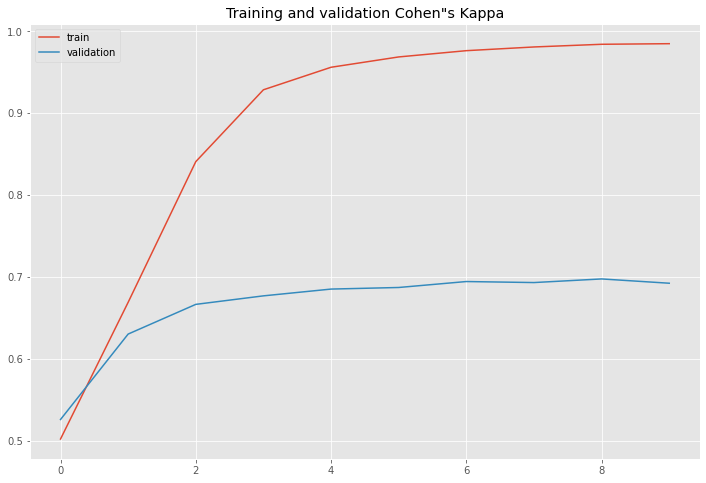

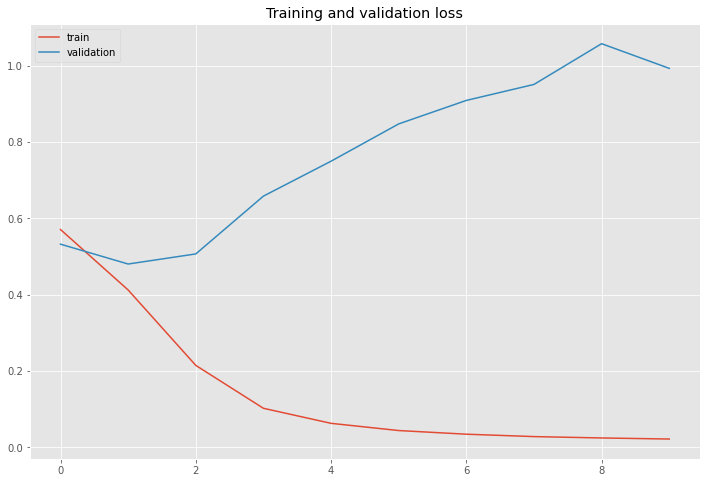

In [207]:
#plot the accuracy and loss
acc = history.history['cohen_kappa']
val_acc = history.history['val_cohen_kappa']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc,label='train')
plt.plot(val_acc, label = 'validation')
plt.title('Training and validation Cohen"s Kappa')
plt.legend()

plt.figure()

plt.plot(loss, label = 'train')
plt.plot(val_loss, label = 'validation')
plt.title('Training and validation loss')
plt.legend()



plt.show()

In [208]:
tokens.fit_on_texts(tests)
length_index = tokens.word_index
print('Found %s unique tokens.' % len(length_index))

Found 34495 unique tokens.


In [209]:
x_test = tokens.texts_to_matrix(tests, mode='binary')
x_test.shape

(53766, 1500)

In [0]:
test_labels_cat = to_categorical(test_labels)

In [211]:
model.evaluate(x_test, test_labels_cat)

53766/53766 [==============================] - 4s 72us/sample - loss: 3.0932 - cohen_kappa: 0.0944


[3.093187071540697, 0.0944103]

In [0]:
pred= argmax(model.predict(x_test), axis = 1)

In [213]:

pred

array([2, 2, 2, ..., 2, 1, 0])

## Show the confusion matrix and Classification report for test_drugs data and predicted values

In [214]:
print(confusion_matrix(pred, test_labels).T)

[[ 4373   867  8257]
 [ 1230   336  3263]
 [ 7607  1805 26028]]


In [215]:
print(classification_report(pred, test_labels))

              precision    recall  f1-score   support

           0       0.32      0.33      0.33     13210
           1       0.07      0.11      0.09      3008
           2       0.73      0.69      0.71     37548

    accuracy                           0.57     53766
   macro avg       0.38      0.38      0.38     53766
weighted avg       0.60      0.57      0.58     53766



## The confusion matrix and classification report above is for the test-drugs
## For the validation data from  train-drugs the confusion matrix and classification report can be found below

In [0]:
y_pred = argmax(model.predict(x_val), axis = 1)
y_true = argmax(y_val_cat, axis = 1)

In [217]:
print(confusion_matrix(y_pred, y_true).T)

[[ 9645   468  1761]
 [  848  2113  1331]
 [ 2010   768 29446]]


In [218]:
print(classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79     12503
           1       0.49      0.63      0.55      3349
           2       0.91      0.90      0.91     32538

    accuracy                           0.85     48390
   macro avg       0.74      0.77      0.75     48390
weighted avg       0.86      0.85      0.85     48390



In [0]:
val_cohen_kappa = cohen_kappa_score(y_true, y_pred)


In [0]:
test_cohen_kappa = cohen_kappa_score(pred, test_labels)

## show the cohens kappa value for the validation data and from the test_data

In [231]:
print('val_cohens andn test_cohens', val_cohen_kappa, test_cohen_kappa)

val_cohens andn test_cohens 0.6923427567492588 0.09441025126450031
